In [3]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.regularizers import l1, l2, l1_l2
from keras.models import load_model


module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.transformers import LinearTransformation, ParabolicTransformation, TrigTransformation, MeanTransformer
from src.preprocessing import *
from src.sliding_window import *
from src.models import *

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Global Var
sliding_window_size = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

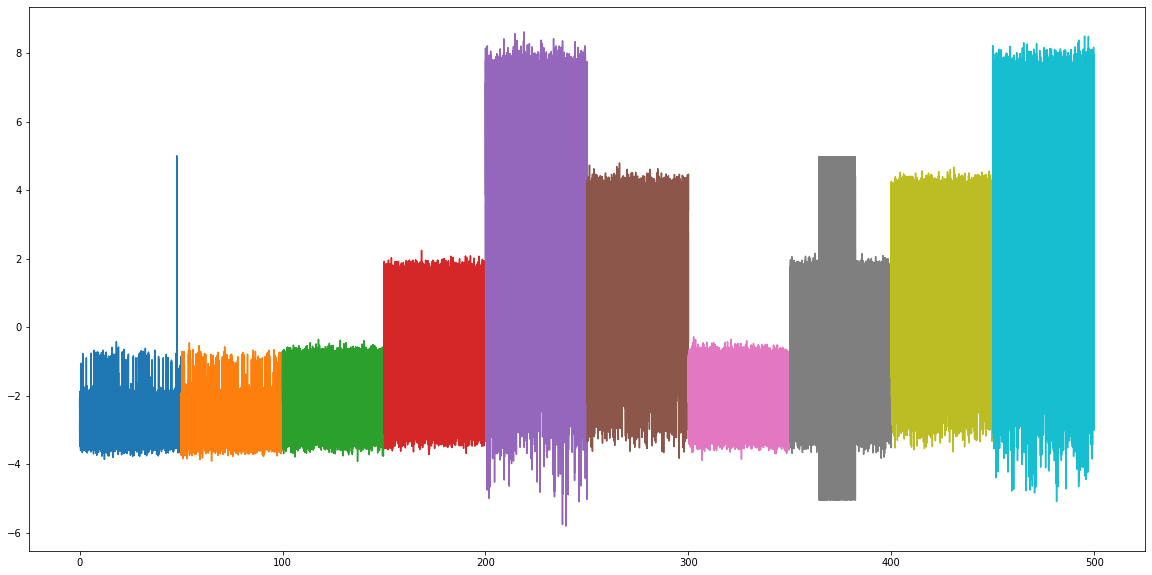

In [5]:
train_chunks = chunk_data(full_data, 10)

lt = LinearTransformation()
pt = ParabolicTransformation()
tt = TrigTransformation(trig_function = 'sin')

train_chunks[1].loc[train_chunks[1].index[:100000], 'signal'] = lt.fit_transform(train_chunks[1][:100000], 3/10, -15)
train_chunks[6]['signal'] = tt.fit_transform(train_chunks[6], 300, 50, 4.95)
train_chunks[7]['signal'] = tt.fit_transform(train_chunks[7], 350, 50, 5.030)
train_chunks[8]['signal'] = tt.fit_transform(train_chunks[8], 400, 50, 4.974)
train_chunks[9]['signal'] = tt.fit_transform(train_chunks[9], 450, 50, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal'])

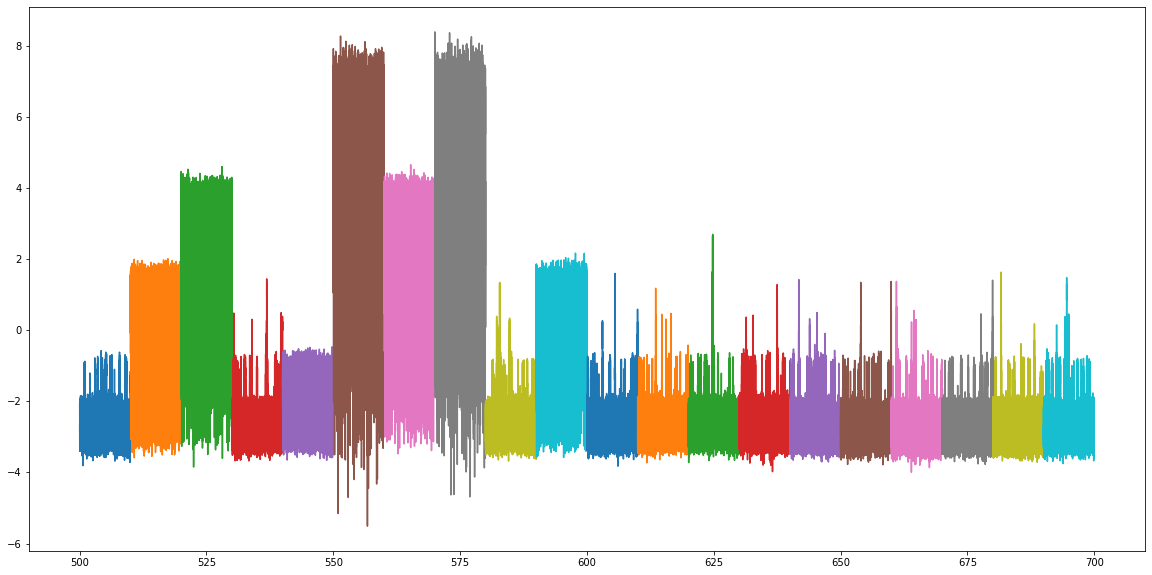

In [6]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0]['signal'] = lt.fit_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1]['signal'] = lt.fit_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4]['signal'] = lt.fit_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6]['signal'] = lt.fit_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7]['signal'] = lt.fit_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8]['signal'] = lt.fit_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10]['signal'] = tt.fit_transform(test_chunks[10], 600, 50, 4.925)

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [7]:
mt = MeanTransformer().fit(0)

for chunk in train_chunks:
    chunk['signal'] = mt.transform(chunk['signal'])
    
for chunk in test_chunks:
    chunk['signal'] = mt.transform(chunk['signal'])

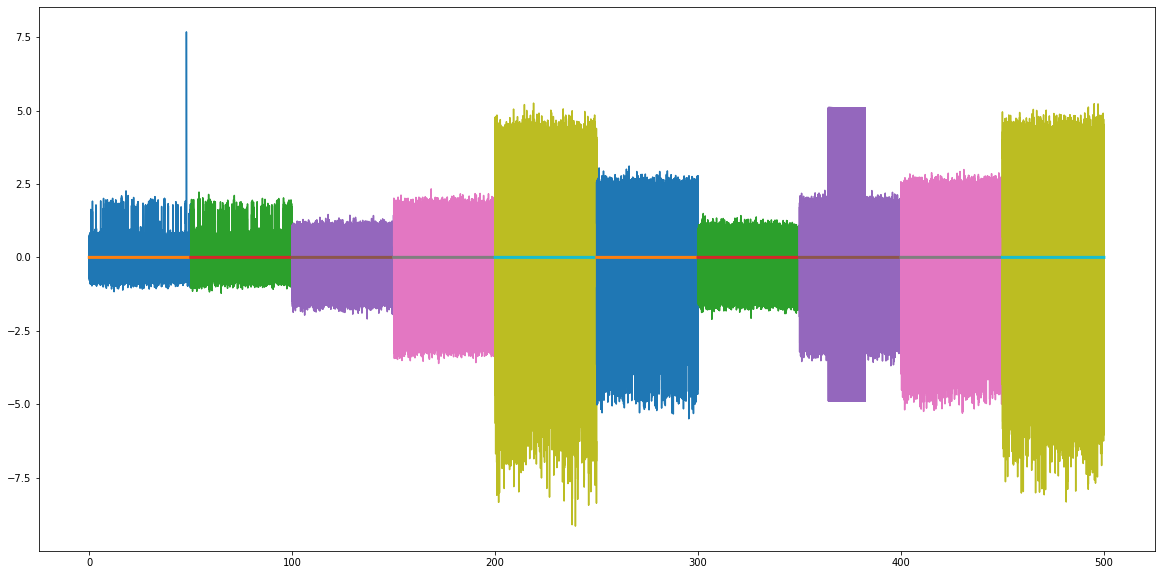

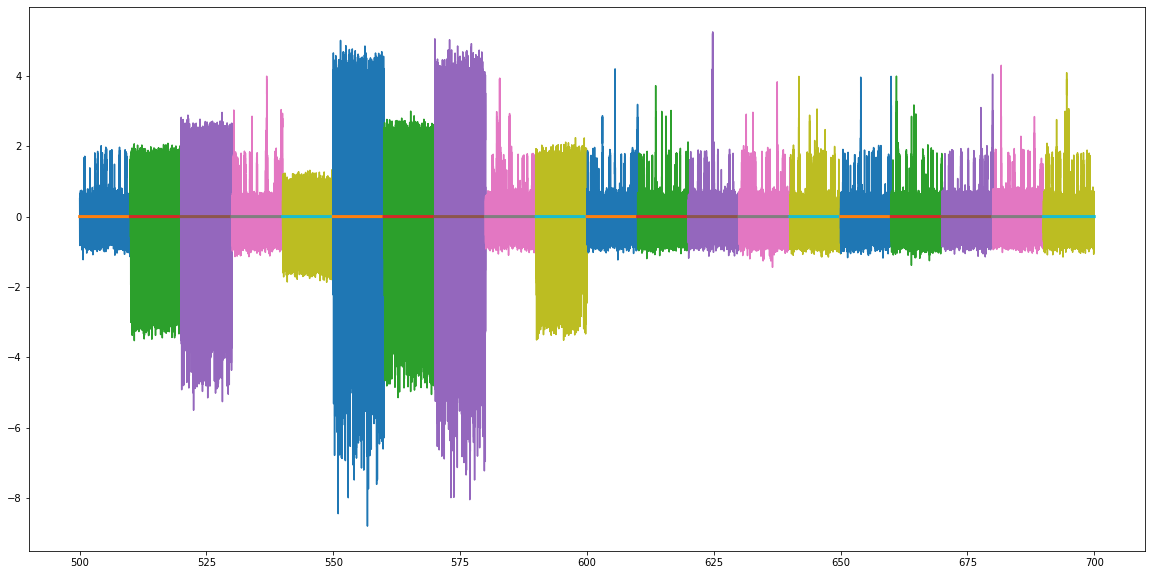

In [8]:
plt.figure(figsize = (20, 10))
for chunk in train_chunks:
    a = chunk

    wind = 1000

    b = a.copy()
    b['signal'] = b['signal'].mean()
    plt.plot(a['time'], a['signal'])
    plt.plot(b['time'], b['signal'], linewidth = 3)



plt.figure(figsize = (20, 10))
for chunk in test_chunks:
    a = chunk

    wind = 1000

    b = a.copy()
    b['signal'] = b['signal'].mean()
    plt.plot(a['time'], a['signal'])
    plt.plot(b['time'], b['signal'], linewidth = 3)

In [9]:
# model1_data = pd.concat([train_chunks[0], train_chunks[1]]).reset_index(drop = True)
# model2_data = pd.concat([train_chunks[2], train_chunks[6]]).reset_index(drop = True)
# model3_data = pd.concat([train_chunks[3]]).reset_index(drop = True)
# model4_data = pd.concat([train_chunks[5], train_chunks[8]]).reset_index(drop = True)
# model5_data = pd.concat([train_chunks[4], train_chunks[9]]).reset_index(drop = True)



# data = [test_chunks[0],
#         test_chunks[3],
#         test_chunks[8],
#         test_chunks[10],
#         test_chunks[11],
#         test_chunks[12],
#         test_chunks[13], 
#         test_chunks[14], 
#         test_chunks[15], 
#         test_chunks[16], 
#         test_chunks[17], 
#         test_chunks[18], 
#         test_chunks[19]]
# model1_test_data = pd.concat(data).reset_index(drop = True)
# model2_test_data = pd.concat([test_chunks[4]]).reset_index(drop = True)
# model3_test_data = pd.concat([test_chunks[1], test_chunks[9]]).reset_index(drop = True)
# model4_test_data = pd.concat([test_chunks[2], test_chunks[6]]).reset_index(drop = True)
# model5_test_data = pd.concat([test_chunks[5], test_chunks[7]]).reset_index(drop = True)

# model1_data.to_csv('../../data/train_data/train1.csv', index = False)
# model2_data.to_csv('../../data/train_data/train2.csv', index = False)
# model3_data.to_csv('../../data/train_data/train3.csv', index = False)
# model4_data.to_csv('../../data/train_data/train4.csv', index = False)
# model5_data.to_csv('../../data/train_data/train5.csv', index = False)

# model1_test_data.to_csv('../../data/test_data/test1.csv', index = False)
# model2_test_data.to_csv('../../data/test_data/test2.csv', index = False)
# model3_test_data.to_csv('../../data/test_data/test3.csv', index = False)
# model4_test_data.to_csv('../../data/test_data/test4.csv', index = False)
# model5_test_data.to_csv('../../data/test_data/test5.csv', index = False)

In [10]:
model5_train = train_chunks[4]
model5_test = train_chunks[9]

In [17]:
make_sliding_window(model5_train['signal'], sliding_window_size).shape

(500000, 20)

In [20]:
nn = RNN(sliding_window_size)
model5 = nn.fit(model5_train['signal'].values, model5_train['open_channels'].values, cycles = 20, epochs = 1)

Cycle 1/20
Train on 325000 samples, validate on 175000 samples
Epoch 1/1
325000/325000 [==============================] - 38s 118us/step - loss: 0.4394 - accuracy: 0.8248 - val_loss: 0.3101 - val_accuracy: 0.8783
Cycle 2/20
Train on 325000 samples, validate on 175000 samples
Epoch 1/1
325000/325000 [==============================] - 39s 121us/step - loss: 0.3139 - accuracy: 0.8753 - val_loss: 0.3182 - val_accuracy: 0.8746
Cycle 3/20
Train on 325000 samples, validate on 175000 samples
Epoch 1/1
325000/325000 [==============================] - 40s 122us/step - loss: 0.3057 - accuracy: 0.8786 - val_loss: 0.3021 - val_accuracy: 0.8783
Cycle 4/20
Train on 325000 samples, validate on 175000 samples
Epoch 1/1
325000/325000 [==============================] - 40s 122us/step - loss: 0.3022 - accuracy: 0.8794 - val_loss: 0.3041 - val_accuracy: 0.8798
Cycle 5/20
Train on 325000 samples, validate on 175000 samples
Epoch 1/1
325000/325000 [==============================] - 39s 119us/step - loss: 0.2

In [21]:
f1_score(model5_test['open_channels'], model5.predict(model5_test['signal']), average = 'macro')

0.8555871004252996

In [23]:
model1_data = pd.read_csv('../../data/train_data/train1.csv')
model2_data = pd.read_csv('../../data/train_data/train2.csv')
model3_data = pd.read_csv('../../data/train_data/train3.csv')
model4_data = pd.read_csv('../../data/train_data/train4.csv')
model5_data = pd.read_csv('../../data/train_data/train5.csv')

model1_test_data = pd.read_csv('../../data/test_data/test1.csv')
model2_test_data = pd.read_csv('../../data/test_data/test2.csv')
model3_test_data = pd.read_csv('../../data/test_data/test3.csv')
model4_test_data = pd.read_csv('../../data/test_data/test4.csv')
model5_test_data = pd.read_csv('../../data/test_data/test5.csv')

In [ ]:
# model1 = RNN(sliding_window_size).fit(model1_data['signal'], model1_data['open_channels'], cycles = 8, epochs = 1)
# print('\n\n')
# time.sleep(600)
# model2 = RNN(sliding_window_size).fit(model2_data['signal'], model2_data['open_channels'], cycles = 8, epochs = 1)
# print('\n\n')
# time.sleep(600)
# model3 = RNN(sliding_window_size).fit(model3_data['signal'], model3_data['open_channels'], cycles = 10, epochs = 1)
# print('\n\n')
# time.sleep(600)
# model4 = RNN(sliding_window_size).fit(model4_data['signal'], model4_data['open_channels'], cycles = 15, epochs = 1)
# print('\n\n')
# time.sleep(600)
# model5 = RNN(sliding_window_size).fit(model5_data['signal'], model5_data['open_channels'], cycles = 20, epochs = 1)

In [40]:
model1 = RNN(sliding_window_size).load_model('../../data/RNN/model1.h5')
model2 = RNN(sliding_window_size).load_model('../../data/RNN/model2.h5')
model3 = RNN(sliding_window_size).load_model('../../data/RNN/model3.h5')
model4 = RNN(sliding_window_size).load_model('../../data/RNN/model4.h5')
model5 = RNN(sliding_window_size).load_model('../../data/RNN/model5.h5')

# model1.model.save('../../data/RNN/model1.h5')
# model2.model.save('../../data/RNN/model2.h5')
# model3.model.save('../../data/RNN/model3.h5')
# model4.model.save('../../data/RNN/model4.h5')
# model5.model.save('../../data/RNN/model5.h5')

In [49]:
preds = model1.predict(model1_test_data['signal'])
preds = np.append(preds, model2.predict(model2_test_data['signal'].values))
preds = np.append(preds, model3.predict(model3_test_data['signal'].values))
preds = np.append(preds, model4.predict(model4_test_data['signal'].values))
preds = np.append(preds, model5.predict(model5_test_data['signal'].values))

time = model1_test_data['time'].values
time = np.append(time, model2_test_data['time'].values)
time = np.append(time, model3_test_data['time'].values)
time = np.append(time, model4_test_data['time'].values)
time = np.append(time, model5_test_data['time'].values)

predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions['time'] = time
predictions['open_channels'] = preds

In [50]:
predictions = predictions.sort_values(by = 'time').reset_index(drop = True)

In [51]:
predictions

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
...,...,...
1999995,699.9996,0
1999996,699.9997,0
1999997,699.9998,0
1999998,699.9999,0


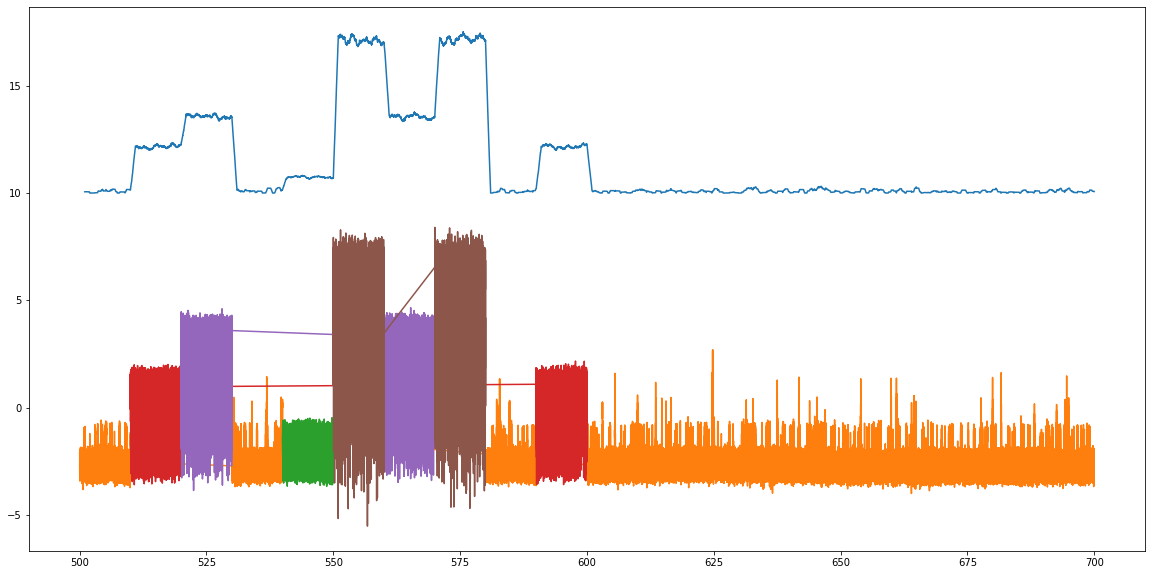

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in [model1_test_data, model2_test_data, model3_test_data, model4_test_data, model5_test_data]:
    plt.plot(i['time'], i['signal'])

In [53]:
predictions.to_csv('~/Desktop/test_predictions2.csv', index = False, float_format='%.4f')
#0.937 preds_12

In [54]:
good_preds = pd.read_csv('~/Desktop/predictions/15_0.939_mean_transformed.csv')

In [55]:
(predictions.open_channels != good_preds.open_channels).sum()

454122

In [56]:
(predictions.open_channels.reset_index(drop=True) != good_preds.open_channels)[:].sum()

454122